In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import json_normalize
import pickle
import math
import numpy as np
import os
from datetime import datetime, timedelta
import re


import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

pd.set_option('max_colwidth', 200)
%config Completer.use_jedi = False
#from helper import toi_add_city_column, hindu_add_city_column, filter_cities

In [5]:
def latexify(fig_width=None, fig_height=None, columns=2):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.32 if columns==1 else 6.75 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax,twinx=False,SPINE_COLOR="gray"):
    
    if twinx:
        for spine in ['top']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom', 'right']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)
        
    else:
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

        for spine in ['left', 'bottom']:
            ax.spines[spine].set_color(SPINE_COLOR)
            ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [6]:
df_articles = pd.read_csv("../dataset/News_articles_dataset/News_articles_dataset.csv.gz")
df_articles["date"] = pd.to_datetime(df_articles["date"])
df_articles.sample(3)

,media,date,url,heading,content,other.author,other.top_image,other.category,city,year,state,district,matches
15738,Hindu,2019-06-03,https://www.thehindu.com/children/tickle-in-his-throat/article27412689.ece,Tickle in his throat,"Slo and Gau came across Jack in the middle of a coughing fit. What, they wondered, could have brought it on?\n\n“Wheez! wheez! cough! splutter...,” went the jackal. He could barely breathe.\n\nThe...",NimiKurian,https://www.thehindu.com/children/571qnu/article27412683.ece/ALTERNATES/LANDSCAPE_615/Illus1jpg,children,NaN,NaN,NaN,NaN,{'smog': 1.0}
3048,TOI,2015-12-17,http://timesofindia.indiatimes.com//city/noida/Foul-air-leads-to-30-rise-in-bronchial-diseases/articleshow/50211620.cms,Foul air leads to 30% rise in bronchial diseases,"\n\nNoida: As the quality of city air reaches hazardous levels, it has started showing its effects on the health of Noida residents. Hospitals in the city are reporting a sudden surge in respirato...","Sharmila Bhowmick / TNN / Dec 17, 2015, 04:19 IST","https://static.toiimg.com/thumb/msid-47529300,width-1070,height-580,imgsize-110164,resizemode-75,overlay-toi_sw,pt-32,y_pad-40/photo.jpg",NaN,noida,2015.0,uttar pradesh,gautam buddha nagar,"{'air quality': 3.0, 'pm 2.5': 1.0}"
16616,Hindu,2020-05-09,https://www.thehindu.com/sci-tech/science/study-finds-heat-wave-like-conditions-in-cars/article31543108.ece,Study finds ‘heat wave-like’ conditions in cars,"They may lead to ailments such as heat stress, heat strokes and fluctuation in blood pressure\n\nThe ambient temperature inside cars could shoot up to as much as 65°C and induce conditions akin to...",JacobKoshy,https://www.thehindu.com/sci-tech/science/xp3ub8/article31543107.ece/ALTERNATES/LANDSCAPE_615/IN09CAR,science,jacobkoshy,NaN,NaN,NaN,{'carbon monoxide': 1.0}


##  Sources

### India

In [7]:
# !conda install openpyxl -y

In [8]:
#data source: http://urbanemissions.info/wp-content/uploads/misc/india_wustl_extracts_pmsa.xlsx
df_sources_india = pd.read_excel("Source_contribution_pm25_india.xlsx",sheet_name="final_bystate")
df_sources_india.head()

,ST_CEN_CD,state_name,DUST,WINDUST,WASTE,RESI,TRANS,POWER,INDUS,BIOB,AGR,OTHER,Unnamed: 12
0,1.0,Jammu & Kashmir,7.602899,8.557988,5.262316,30.723745,11.050788,7.252404,14.124743,1.338199,10.391891,3.695359,JK
1,2.0,Himachal Pradesh,7.897604,6.376178,4.443600,28.651499,11.402736,8.669375,13.665820,2.481085,12.525487,3.886562,HP
2,3.0,Punjab,10.388898,4.192453,4.311272,31.647284,10.676158,8.458820,13.173587,3.333891,10.430349,3.387287,PB
3,4.0,Chandigarh,11.801000,4.184000,4.050000,26.584000,10.048000,10.473000,14.715000,2.494000,12.180000,3.473000,CH
4,5.0,Uttarakhand,8.838814,4.485787,4.038621,30.151010,10.948515,10.288065,12.633006,4.610603,10.897680,3.108411,UK


In [9]:
#This sheet is created by us to aggregate primary sources of air pollution
#Category in original study mentioned as Source_code
#Aggregated name of source mentioned as Source_name
df_sources_delhi = pd.read_excel("Source_contribution_pm25_delhi.xlsx", sheet_name="Aggregated_sources").iloc[:,1:-1]
df_sources_delhi

,Source code,Contriution_Delhi,Source_name
0,DUST,11.8,Dust
1,WINDUST,2.7,Dust
2,WASTE,3.1,Open Burning
3,RESI,32.3,Residential Biomass
4,TRANS,8.0,Vehicular Emissions
5,POWER,11.0,Industry and Energy production
6,INDUS,16.7,Industry and Energy production
7,BIOB,2.4,Open Burning
8,AGR,8.4,NaN
9,OTHER,3.5,NaN


In [10]:
df_source_contr_del = df_sources_delhi.groupby("Source_name").sum().reset_index() #aggregated source and its contribution
df_source_contr_del.columns = ["source","perc_contribution"]
df_source_contr_del.sort_values(by="perc_contribution",inplace=True,ascending=False) #sort
df_source_contr_del

,source,perc_contribution
3,Residential Biomass,32.3
1,Industry and Energy production,27.7
0,Dust,14.5
4,Vehicular Emissions,8.0
2,Open Burning,5.5


In [11]:

# sources_contribution_del = {
#     "Residential biomass":23.8,
#     "Coal": 9.1, #+ 2.9 + 6.3,      #total coal+ industrical coal + powerplants coal
#     "Transportation":3.6, # Transportation+ Distributed diesel
#     "Open burning":18.8,
#     "Brick production":2.4,
#     "Dust":38.1 #+ 13.9 #Anthropogenic dust + total dust
# }

# sources_contribution_del = {
#     "Residential biomass":32.3,
#     "Industry and Energy production": 27.7,
#     "Transportation":8, 
#     "Open burning":5.5,
#     "Dust":14.5 #+ 13.9 
# }


# df_source_contr_del = pd.DataFrame(sources_contribution_del.items(),columns=["source","perc_contribution"]).nlargest(10,"perc_contribution")
# df_source_contr_del

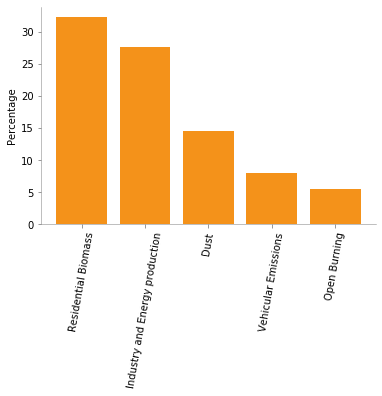

In [12]:
fig,ax = plt.subplots()
#print(total_articles)
#ax.set_title(f"Causes - {total_articles} articles")
ax.bar(df_source_contr_del["source"],df_source_contr_del["perc_contribution"],color="#f4921a")
ax.tick_params(axis="x",rotation=80)
# ax.tick_params(axis="y",labelsize=15)
ax.set_ylabel("Percentage")
#ax.grid(axis="y")
#ax.legend(fontsize=12)
format_axes(ax)
fig.show()

In [13]:

sources_HEI_queries = {
    "Residential Biomass":["biomass fuels","wood burning","burning wood",
                           "firewood","cooking","household air pollution"], 
    
 
    
    "Vehicular Emissions": ["vehicles?","petrol","diesel","vehicular emissions"],
    
    
    "Open Burning":["open burning","garbage burning","burning garbage","burning waste","waste burning",
                    "burning organic waste","crop burning","stubble","burning crops?","burning paddy",
                    "paddy burning","crop residue"],
    
    
    
    "Industry and Energy production":["energy sector","energy production","coal","power plant","industry",
                                      "industrial pollution","polluting industries","industrial emissions",
                                      "fossil fuel"] ,
    
    "Dust":["[\s,)(-]dust[-\s,)(.]","construction","demolition"],
    
}

#"Brick production":["[\s,)(-]brick[\s,)(-s.]"],
#"Coal":["[\s,)(-]coal[-\s,)(.]"],

In [14]:
def get_regex_string_from_single_word(keyword,space=False,dostrip=True):
    
    #to check empty string before the keyword
    re_str = ""
    space = ""
    if space:
        space = "\\b"
        re_str+=space
    keyword = keyword.lower()
    if dostrip:
        keyword = keyword.strip()
    words = keyword.split(" ")
    n = len(words)
    for ind,word in enumerate(words):
        re_str+=word
        if ind+1 < n:
            #to accept white space between two word
            re_str+="\\s"
    
    #to check empty string after the keyword
    re_str+= space
    return re_str

def get_matches(text,queries,print_re=False,print_matches=False,dostrip=True):
    '''
    regex serach from text using queris
    returns list of keyword matches
    '''
    re_str = ""
    for each in queries:
        re_str = re_str + get_regex_string_from_single_word(each,dostrip) + "|"
    re_str = re_str[:-1]
    if print_re:
        print(re_str)
    if print_matches:
        print(re.findall(re_str,text,flags=re.I))
    return re.findall(re_str,text,flags=re.I)

def get_frequency_of_keyword(df,keyword_dict,column="content",dostrip=True):
    '''
    frequency of keyword from given df using given queries(keyword_dict)
    '''
    keyword_freq = {}
    for key in keyword_dict:
        df[key] = df[column].apply(get_matches,queries=keyword_dict[key],dostrip=dostrip)
        temp_multi = df[df[key].apply(lambda x:len(x)>0)]

        print(f"{key}-{len(temp_multi)}")
        keyword_freq[key] = len(temp_multi)
        
    #transpose & et frquency
    freq_df = pd.DataFrame(keyword_freq,index=range(len(keyword_freq))).T[0]
    freq_df = freq_df.reset_index()
    freq_df.columns = ["keyword","frequency"]
    freq_df = freq_df.sort_values(by="frequency",ascending=False)
    return freq_df


def filter_cities(which_df,allowed_cities):
    '''
    gives only those rows of dataframe which "city" columns
    contains given cities
    allowed cities can be one city or list of cities
    '''
    if type(allowed_cities) == str:
        allowed_cities = [allowed_cities]
    #remove NA values in city
    which_df = which_df.dropna(subset=["city"])

    #city can be list or str
    filtered_df = which_df[which_df["city"].apply(lambda city: True in [each.lower().strip() in city for each in allowed_cities] if type(city) == str or type(city) == list else False)]
    return filtered_df

def get_count_of_total_related_articles(df,which_dict,column = "heading_and_content"):
    '''
    total count of related articles of given topic
    '''
    queries = []
    for key in which_dict:
        queries.extend(which_dict[key])
    new_col = "causes"
    df[new_col] = df[column].apply(get_matches,queries=queries)
    temp_multi = df[df[new_col].apply(lambda x:len(x)>0)]
    return len(temp_multi)

In [15]:
#get df of frequency of each topic
#sources_freq = h.get_frequency_of_keyword(df_articles,sources_HEI_queries,"heading_and_content")
df_del = filter_cities(df_articles,["delhi","new delhi","newdelhi"])
print(len(df_del))
sources_freq_del = get_frequency_of_keyword(df_del,sources_HEI_queries,"content")
sources_freq_del

5296
Residential Biomass-71
Vehicular Emissions-1625
Open Burning-1242
Industry and Energy production-754
Dust-1285


,keyword,frequency
1,Vehicular Emissions,1625
4,Dust,1285
2,Open Burning,1242
3,Industry and Energy production,754
0,Residential Biomass,71


In [16]:
total_articles = get_count_of_total_related_articles(df_del,sources_HEI_queries,column="content")
print(total_articles)

3285


In [19]:
#3115/5201
69/3119

0.0221224751522924

In [20]:
#merged_df = df_source_contr.merge(sources_freq_del,left_on="source",right_on="keyword")
merged_df_del = df_source_contr_del.merge(sources_freq_del,left_on="source",right_on="keyword")
merged_df_del

,source,perc_contribution,keyword,frequency
0,Residential Biomass,32.3,Residential Biomass,71
1,Industry and Energy production,27.7,Industry and Energy production,754
2,Dust,14.5,Dust,1285
3,Vehicular Emissions,8.0,Vehicular Emissions,1625
4,Open Burning,5.5,Open Burning,1242


In [21]:
merged_df_del["perc_articles"] = merged_df_del["frequency"].apply(lambda x:100*x/total_articles)
merged_df_del

,source,perc_contribution,keyword,frequency,perc_articles
0,Residential Biomass,32.3,Residential Biomass,71,2.161339
1,Industry and Energy production,27.7,Industry and Energy production,754,22.952816
2,Dust,14.5,Dust,1285,39.117199
3,Vehicular Emissions,8.0,Vehicular Emissions,1625,49.467275
4,Open Burning,5.5,Open Burning,1242,37.808219


In [22]:
# merged_df_del.replace({
#     "Residential biomass" : "Residential\nBiomass",
#     "Open burning": "Open\nBurning",
#     "Brick production": "Brick\nProduction",
#     "Transportation": "Vehicular\nEmissions"
# }, inplace=True)

merged_df_del.replace({
    "Residential biomass" : "Residential\nBiomass",
    "Residential Biomass" : "Residential\nBiomass",
    "Open burning": "Open\nBurning",
    "Open Burning": "Open\nBurning",
    "Industry and Energy production": "Industry\nand Energy\nproduction",
    "Transportation": "Vehicular\nEmissions",
    "Vehicular Emissions":'Vehicular\nEmissions'
}, inplace=True)

In [23]:
#merged_df_del.replace({"Residential\nBiomass":"RB","Open\nBurning":"OB",
#                       "Vehicular\nEmissions":"VE","Brick\nProduction":"BP"},inplace=True)
merged_df_del

,source,perc_contribution,keyword,frequency,perc_articles
0,Residential\nBiomass,32.3,Residential\nBiomass,71,2.161339
1,Industry\nand Energy\nproduction,27.7,Industry\nand Energy\nproduction,754,22.952816
2,Dust,14.5,Dust,1285,39.117199
3,Vehicular\nEmissions,8.0,Vehicular\nEmissions,1625,49.467275
4,Open\nBurning,5.5,Open\nBurning,1242,37.808219


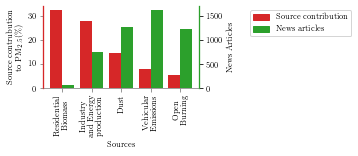

In [34]:
#get count of releted articles
#total_articles = h.get_count_of_total_related_articles(df,sources)
#print(total_articles)

import matplotlib
import matplotlib.pyplot as plt

latexify(columns=1,fig_height=1.5,fig_width=2.8)

which_merged_df = merged_df_del

fig,ax = plt.subplots()
ax2 = ax.twinx()

n_sources = len(which_merged_df)
width = 0.4
x = np.arange(0,n_sources,1)

source_color = "tab:red"
article_color = "tab:green"

#sources contrinbution
ax.tick_params(axis="x",rotation=90)
plt1 = ax.bar(x,which_merged_df["perc_contribution"],color=source_color,label="Source contribution",width=width)
ax.set_ylabel("Source contrubution\nto PM$_{2.5}$(\%)")
ax.set_xlabel("Sources")

#news articles
plt2 = ax2.bar(x+width,which_merged_df["frequency"],label="News articles",width=width,color=article_color)
ax2.set_ylabel("News Articles")

ax.set_xticks(x+width/2)

ax.set_xticklabels(which_merged_df["source"])

format_axes(ax)
plts = plt1+plt2
labels = [plt1.get_label(),plt2.get_label()]
ax.legend(plts,labels,bbox_to_anchor=(2,1))

leg = ax.get_legend()
leg.legendHandles[0].set_color(source_color)
leg.legendHandles[1].set_color(article_color)

for ax in [ax,ax2]:
    for spine in ['top']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom', 'right']:
        ax.spines[spine].set_color("gray")
        ax.spines[spine].set_linewidth(0.5)
    
ax.spines["left"].set_color(source_color)
ax.spines["right"].set_color(article_color)
ax.spines["left"].set_linewidth(1.3)
ax.spines["right"].set_linewidth(1.3)

fig.show()
#fig.savefig("plots/latex/sources_barplot.pdf",bbox_inches="tight")

In [35]:
fig.savefig("../figures/fig9_source_contriution_delhi_revised.pdf",bbox_inches="tight")

In [30]:
matplotlib.__version__

'3.1.3'